In [1]:
%matplotlib ipympl
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.special import kv
import scipy.constants as c
from uncertainties import unumpy
from astropy.timeseries import LombScargle
from onix.analysis.functions.lf_ramsey_shared import analyze_data
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import get_results
from onix.papers.axion_2024.lomb_scargle import frequency_sensitivity_from_experiment_times, ls_psd_to_power_spectrum
from onix.papers.axion_2024.axion_gluon_bounds import best_exp_bounds, worse_exp_bounds, model_dep_theory_bounds, model_indep_theory_bounds
from onix.papers.axion_2024.axion_gluon import S_Flambaum, S_Sushkov, S_geo_mean, E_xtl, theta_from_W_T

In [2]:
raw_data = np.load("raw_data.npz")
start_times = raw_data["start_times"]
end_times = raw_data["end_times"]
Zs = raw_data["Zs"]
W_Ts = raw_data["W_Ts"]

center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
center_time_offsetted_h = center_time_offsetted / 3600
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]
delta_W_Ts = W_Ts - np.average(W_Ts)

cycle_time_avg = np.average(cycle_times)
cycle_frequency_avg = 1 / cycle_time_avg
W_T_unc = np.std(W_Ts) / np.sqrt(num_of_cycles)

In [3]:
frequency_sensitivities = np.load("frequency_sensitivities.npz")
sensitivity_func = interp1d(frequency_sensitivities["freqs_test"], frequency_sensitivities["sensitivities"])

In [4]:
square_thetas_gm = theta_from_W_T(delta_W_Ts, S_geo_mean, E_xtl, absolute=False) ** 2

In [24]:
ls = LombScargle(center_times, square_thetas_gm, normalization="psd")

min_freq = 0.5 / total_duration
max_freq = 0.5 / cycle_time_avg
fs, f_square_thetas_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
power_square_thetas = ls_psd_to_power_spectrum(f_square_thetas_psd, num_of_cycles)
sample_rate = num_of_cycles / total_duration
psd_square_thetas = f_square_thetas_psd * 2 / sample_rate

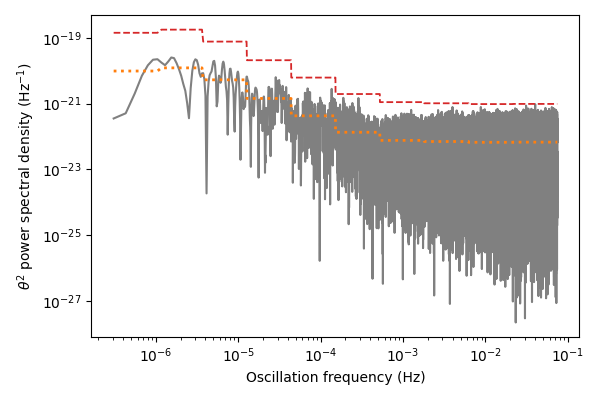

In [25]:
fs_bins = np.logspace(np.log10(np.min(fs) - 1e-10), np.log10(np.max(fs) + 1e-10), 10 + 1)
square_theta_binned_indices = np.digitize(fs, fs_bins)
square_theta_binned = []
for kk in range(1, len(fs_bins)):
    psd_square_theta_same_bin = psd_square_thetas[square_theta_binned_indices==kk]
    square_theta_binned.extend([np.average(psd_square_theta_same_bin)] * len(psd_square_theta_same_bin))
square_theta_binned = np.array(square_theta_binned)
global_95_square_theta_bound = -np.log(1 - 0.95 ** (1/num_of_cycles)) * square_theta_binned
local_95_square_theta_bound = -np.log(1 - 0.95) * square_theta_binned

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, psd_square_thetas, label="data", color="gray")
ax.plot(fs, square_theta_binned, label="binned average", color="C1", ls="dotted", linewidth=2)
ax.plot(fs, global_95_square_theta_bound, label=f"95% confidence level", color="C3", linewidth=1.3, ls="dashed")
ax.set_ylabel("$\\theta^2$ power spectral density (Hz$^{-1}$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [26]:
global_95_square_theta_bound_corrected = global_95_square_theta_bound / sensitivity_func(fs)**2
local_95_square_theta_bound_corrected = local_95_square_theta_bound / sensitivity_func(fs)**2
fs_natural = fs * c.h
sigma = 160e3
sigma_natural = sigma / c.c

## method 1

In [8]:
masses_f = np.logspace(-1, 12, 100)
masses = axion_frequency_to_mass(masses_f)
masses_natural = masses * c.e

min_omega_bar_limit = 0.34  # arbitrarily selected.
min_factor_in_data = 10
max_fs_natural_within_min_omega_bar = min_omega_bar_limit * (masses_natural * sigma_natural**2)
psd_square_thetas_avg = []
for kk in max_fs_natural_within_min_omega_bar:
    if kk / min_factor_in_data < np.min(fs_natural) or kk > np.max(fs_natural):
        psd_square_thetas_avg.append(np.inf)
    else:
        fs_mask = fs_natural < kk
        psd_square_thetas_avg.append(np.average(global_95_square_theta_bound[fs_mask]))
psd_square_thetas_avg = np.array(psd_square_thetas_avg)
psd_square_thetas_avg_natural = psd_square_thetas_avg / c.h

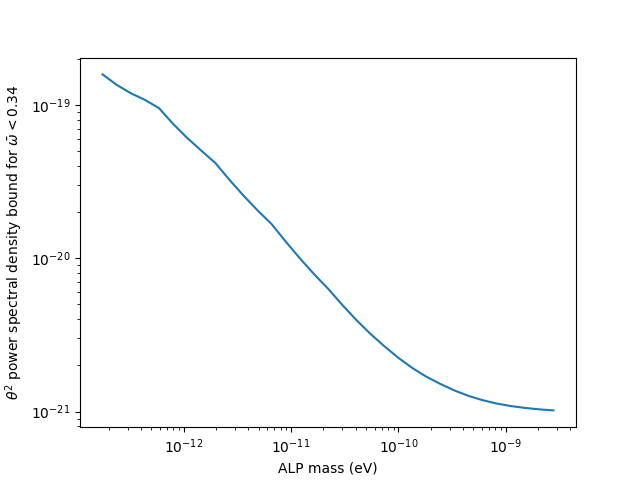

In [9]:
fig, ax = plt.subplots()
ax.plot(masses, psd_square_thetas_avg)
ax.set_xlabel("ALP mass (eV)")
ax.set_ylabel("$\\theta^2$ power spectral density bound for $\\bar{\\omega} < " + str(min_omega_bar_limit) + "$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [10]:
thetas_avg = (psd_square_thetas_avg_natural * masses_natural * sigma_natural**2) ** (1/4)

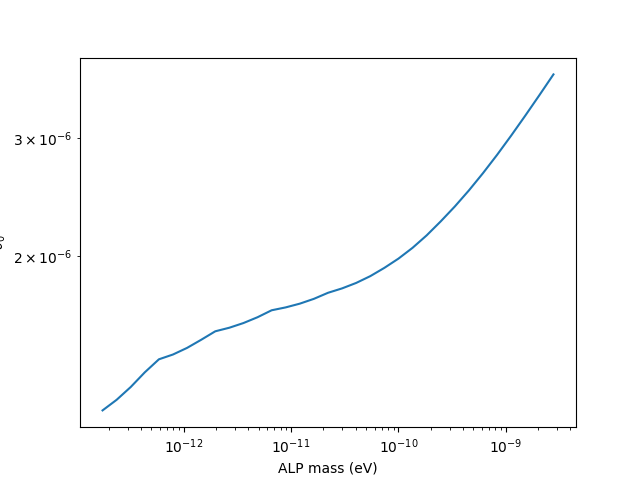

In [11]:
fig, ax = plt.subplots()
ax.plot(masses, thetas_avg)
ax.set_xlabel("ALP mass (eV)")
ax.set_ylabel("$\\theta_0$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [17]:
masses_plt = masses[~np.isinf(thetas_avg)]
inverse_fa_bound_geo_mean = inverse_fa_limit(masses_f[~np.isinf(thetas_avg)], thetas_avg[~np.isinf(thetas_avg)])

## method 2

In [27]:
masses_f = np.logspace(-1.2, 9, 50)
masses = axion_frequency_to_mass(masses_f)
masses_natural = masses * c.e
masses_plt = masses


taus_a = c.hbar / (masses * c.e / c.c**2 * sigma**2)
total_theoretical_power_in_theta_0_fourth_power = [np.sum(
    taus_a[kk] * 2 * np.pi * fs * taus_a[kk] * kv(1, 2 * np.pi * fs * taus_a[kk])
) * (fs[1] - fs[0]) for kk in range(len(taus_a))]
total_theoretical_power_in_theta_0_fourth_power = np.array(total_theoretical_power_in_theta_0_fourth_power)
total_experiment_power_bound = np.sum(local_95_square_theta_bound_corrected) * (fs[1] - fs[0])
inverse_fa_bound_geo_mean = inverse_fa_limit(
    masses_f,
    (total_experiment_power_bound / total_theoretical_power_in_theta_0_fourth_power) ** (1/4),
)


# taus_a_natural = 1 / (masses_natural * sigma_natural**2)
# total_theoretical_power_in_theta_0_fourth_power = [np.sum(
#     taus_a_natural[kk] * 2 * np.pi * fs_natural * taus_a_natural[kk] * kv(1, 2 * np.pi * fs_natural * taus_a_natural[kk])
# ) * (fs[1] - fs[0]) for kk in range(len(taus_a_natural))]
# total_experiment_power_bound = np.sum(local_95_square_theta_bound_corrected) * (fs[1] - fs[0]) / c.h
# inverse_fa_bound_geo_mean = inverse_fa_limit(
#     masses_f,
#     (total_experiment_power_bound / total_theoretical_power_in_theta_0_fourth_power) ** (1/4),
# )

## plot

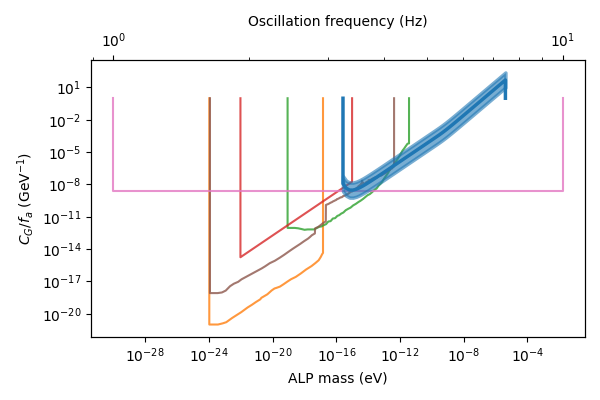

In [28]:
inverse_fa_bound_Flambaum = inverse_fa_bound_geo_mean * S_geo_mean / S_Flambaum
inverse_fa_bound_Sushkov = inverse_fa_bound_geo_mean * S_geo_mean / S_Sushkov

fig, ax = plt.subplots(figsize=(6, 4))
ax1 = ax.twiny()
counter = 1
for kk in best_exp_bounds:
    temp_x = best_exp_bounds[kk][0]
    temp_y = best_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C{counter}")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
for kk in worse_exp_bounds:
    temp_x = worse_exp_bounds[kk][0]
    temp_y = worse_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C7")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1 or counter == 4:
        counter += 1
for kk in model_indep_theory_bounds:
    temp_x = model_indep_theory_bounds[kk][0]
    temp_y = model_indep_theory_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C6")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C6")
    counter += 1
    if counter == 1:
        counter += 1
ax.plot(
    np.append(np.append(masses_plt[0], masses_plt), masses_plt[-1]),
    np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
    color="C0", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=2.5,
)
ax.fill_between(masses_plt, inverse_fa_bound_Flambaum, inverse_fa_bound_Sushkov, zorder=counter, color="C0", alpha=0.6,  linewidth=2.5)

# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1
# )
# ax.plot(
#     masses,
#     inverse_fa_bound_geo_mean,
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=2.5,
# )
# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_Flambaum), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=0.5
# )
ax.set_ylabel("$C_G / f_a$ (GeV${}^{-1}$)")
ax.set_xlabel("ALP mass (eV)")
ax1.set_xscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(0.5e-16, 1e-10)
#ax.set_xticks([1e-22, 1e-21, 1e-18, 1e-15, 1e-12])
#ax.set_xlim(2e-22, 2e-15)
#ax1.set_xlim(axion_mass_to_frequency(2e-22), axion_mass_to_frequency(2e-15))
#ax1.set_xticks([1e-9, 1e-7, 1e-5, 1e-3, 0.1, 10, 1000])
ax1.set_xlabel("Oscillation frequency (Hz)")
#ax.legend()
plt.tight_layout()
plt.show()

In [29]:
np.savez(
    "stochastic_fluctuations.npz",
    masses=masses_plt,
    inverse_fa_bound_geo_mean=inverse_fa_bound_geo_mean,
)

## Asympotic analysis

array([1.27489451e-21, 1.78485443e-21, 2.29481434e-21, ...,
       3.07666719e-16, 3.07667229e-16, 3.07667739e-16])

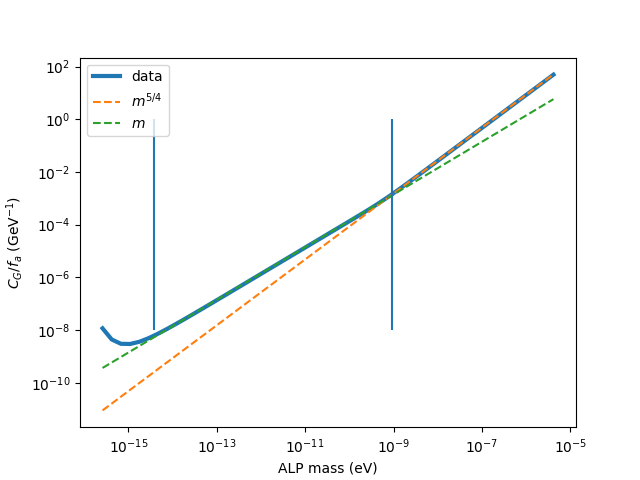

In [56]:
fig, ax = plt.subplots()
ax.plot(masses_plt, inverse_fa_bound_geo_mean, linewidth=3, label="data")
ax.plot(masses_plt, masses_plt ** (5/4) * 2.7e8, ls="--", label="$m^{5/4}$")
ax.plot(masses_plt, masses_plt * 1.4e6, ls="--", label="$m$")
fs_range = np.array([min(fs_natural / c.e), max(fs_natural / c.e)])

ax.vlines(fs_range * 3e6, 1e-8, 1)
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ALP mass (eV)")
ax.set_ylabel("$C_G / f_a$ (GeV$^{-1}$)")
plt.show()

## Exponential distribution confirmation

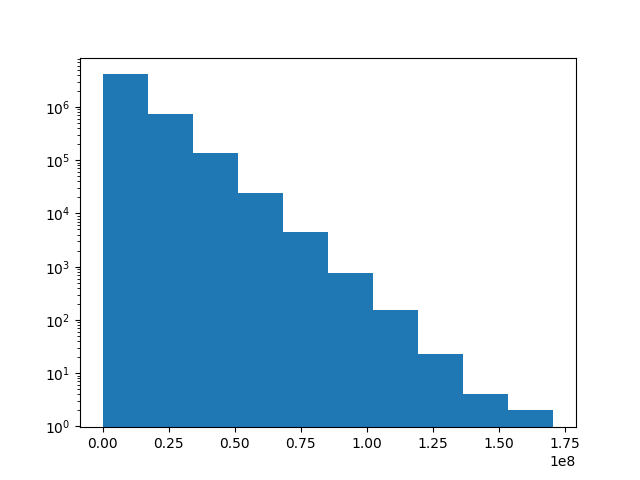

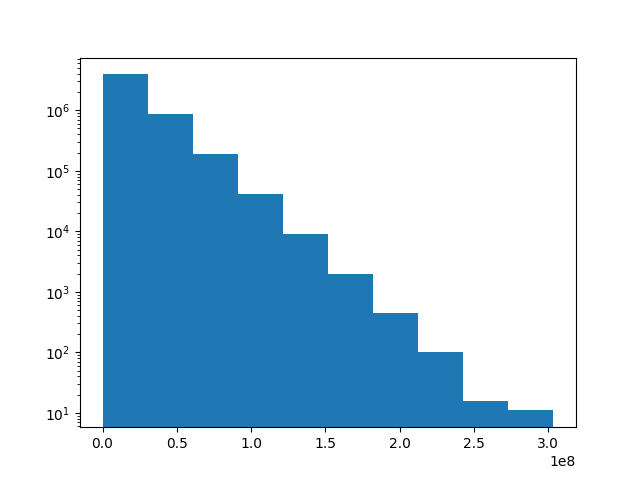

In [29]:
temp_x = np.random.normal(size=10000000)
temp_f_x = np.abs(np.fft.rfft(temp_x)[1:])
temp_P_x = temp_f_x ** 2
temp_f_x_sq = np.abs(np.fft.rfft(temp_x**2)[1:])
temp_P_x_sq = temp_f_x_sq ** 2
fig, ax = plt.subplots()
ax.hist(temp_P_x)
ax.set_yscale("log")
plt.show()
fig, ax = plt.subplots()
ax.hist(temp_P_x_sq)
ax.set_yscale("log")
plt.show()